In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

Parameters of the largest circle:
Center: (110, 258)
Radius: 15
Sigma value 2.0


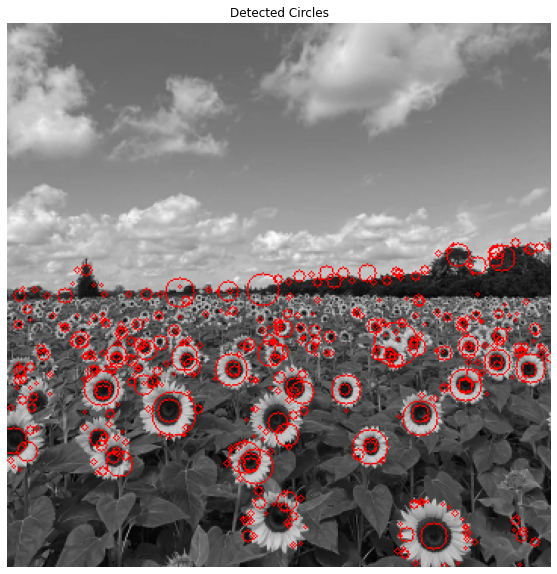

In [13]:
# Load the image
image = cv.imread('Data/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

#Set up parameters for scale-space extrema detection
min_sigma = 1.0  # Minimum sigma value 
max_sigma = 2.0  # Maximum sigma value 
num_sigma = 2 # Number of sigma 
threshold = 0.35  # Threshold 

circles = []

#Loop through sigma values to detect blobs at different scales
for sigma in np.linspace(min_sigma, max_sigma, num_sigma):

    #Apply LoG to grayscale image with the current sigma
    blurred = cv.GaussianBlur(gray_image, (0,0), sigma)
    laplacian = cv.Laplacian(blurred, cv.CV_64F)

    #Absolute Laplacian values
    abs_laplacian = np.abs(laplacian)

    #Binary image where blobs are detected using the threshold
    blob_mask = abs_laplacian > threshold * abs_laplacian.max()

    #Contours in the blob mask
    contours, _ = cv.findContours(blob_mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    #Loop through the detected contours and fit circles to them
    for contour in contours:
        if len(contour) >= 5:
            (x, y), radius = cv.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius, sigma))

#Sort the detected circles by radius in descending order
circles.sort(key=lambda x: -x[1])

#Report the parameters of the largest circle
largest_circle = circles[0]
center, radius, sigma = largest_circle

print("Parameters of the largest circle:")
print("Center:", center)
print("Radius:", radius)
print("Sigma value", sigma)

#Desired line thickness for drawn circles
line_thickness = 1

# Draw all detected circles with the specified line thickness
output_image = cv.cvtColor(gray_image, cv.COLOR_GRAY2BGR)
for circle in circles:
    center, radius, _ = circle
    cv.circle(output_image, center, radius, (0, 0, 255), line_thickness)  # Red color

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected Circles')
plt.show()




Number of inliers (line): 16
Parameters of the estimated line:
a: 0.7080986693010423
b 0.7061134997534697
d: 1.5303717301982513
Number of remaining points: 84
Number of inliers in the circle: 16
Parameters of the estimated circle:
x_center: 2.0388812056906938
y_center: 2.905374551155992
radius: 9.971739443086292


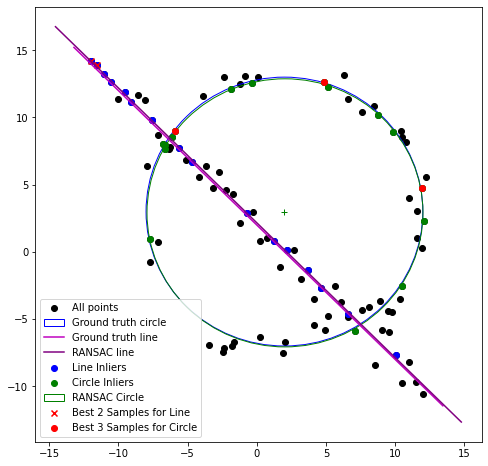

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(1)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = s * np.random.randn(half_n)
x_circle = x0_gt + (r + noise) * np.cos(theta)
y_circle = y0_gt + (r + noise) * np.sin(theta)

X_circ = np.column_stack((x_circle, y_circle))

# Generate points for the line
s = 1.0
m, b = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s * np.random.randn(half_n)

X_line = np.column_stack((x_line, y_line))

# Concatenate points from circle and line to create X
X = np.vstack((X_circ, X_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], color='black', marker='o', label='All points')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt)
ax.plot(x0_gt, y0_gt, '+g')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = m * x_range + b
plt.plot(x_range, y_range, color='m', label='Ground truth line')


#Calculate the line equation from two points
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

#RANSAC to fit a line with unit normal constraint
def ransac_line(X, iter, thresh, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iter):
        sample_indices = np.random.choice(len(X), 2, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        
        a, b, d = line_equation_from_points(x1, y1, x2, y2)
        
        #Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        #Calculate the distance of all points to the line
        distances = np.abs(a*X[:,0] + b*X[:,1] - d)
        
        #Find inliers based on the threshold
        inliers = np.where(distances < thresh)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

#RANSAC parameters
iterations = 10000
threshold = 0.15
min_inliers = 15

#Estimate the line using RANSAC
best_line_model, line_inlier_indices = ransac_line(X_line, iterations, threshold, min_inliers)

print("Number of inliers (line):", len(line_inlier_indices))
print("Parameters of the estimated line:")
print("a:", best_line_model[0])
print("b", best_line_model[1])
print("d:", best_line_model[2])


#Calculate the circle equation from three points
def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    #Midpoints of two line segments
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x2 + x3) / 2, (y2 + y3) / 2
    
    #slopes of the two lines
    if y2 - y1 == 0:
        slope1 = 0  # Avoid zero divion
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0:
        slope2 = 0  
    else:
        slope2 = (x3 - x2) / (y3 - y2)
    
    #Center of the circle
    x_center = (slope1 * mx1 - slope2 * mx2 + my2 - my1) / (slope1 - slope2)
    y_center = -slope1 * (x_center - mx1) + my1
    
    #Radius of the circle
    radius = np.sqrt((x1 - x_center)**2 + (y1 - y_center)**2)
    
    return x_center, y_center, radius

#RANSAC to fit a circle
def ransac_circle(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 3, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        x3, y3 = X[sample_indices[2]]
        
        x_cen, y_cen, radius = circle_equation_from_points(x1, y1, x2, y2, x3, y3)
        
        #Radial error of all points to the circle
        errors = np.abs(np.sqrt((X[:, 0] - x_cen)**2 + (X[:, 1] - y_cen)**2) - radius)
        
        #Inliers based on the threshold
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_cen, y_cen, radius)
                best_inliers = inliers
                
    return best_model, best_inliers

#RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.2  
circle_min_inliers = 15

#The remaining points
remnaning_indices = [i for i in range(len(X)) if i not in line_inlier_indices]
remaining_points = X[remnaning_indices]

#Print the number of remining points
print("Number of remaining points:", len(remaining_points))

#Estimate the circle using RANSAC
best_circle_model, circle_inlier_indices = ransac_circle(remaining_points, circle_iterations, circle_threshold, circle_min_inliers)

# print(best_circle_model)
print("Number of inliers in the circle:", len(circle_inlier_indices))
print("Parameters of the estimated circle:")
print(f"x_center: {best_circle_model[0]}")
print(f"y_center: {best_circle_model[1]}")
print(f"radius: {best_circle_model[2]}")

# Plot the results
# Plot the estimated line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[0] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line', color='purple')


ax.scatter(X_line[line_inlier_indices, 0], X_line[line_inlier_indices, 1], color='blue', label='Line Inliers')


# Find the best 2 samples for the line
best_line_sample_indices = line_inlier_indices[:2]
best_line_samples = X_line[best_line_sample_indices]


#Plot the inliers of the circle
ax.scatter(remaining_points[circle_inlier_indices, 0], remaining_points[circle_inlier_indices, 1], color='g', label='Circle Inliers')

#Estimated circle
x_center, y_center, radius = best_circle_model
circle_estimated = plt.Circle((x_center, y_center), radius, color='g', fill=False, label='RANSAC Circle')
ax.add_artist(circle_estimated)

#best 3 samples for the circle (using circle_inlier_indices)
best_circle_sample_indices = circle_inlier_indices[:3]
best_circle_samples = remaining_points[best_circle_sample_indices]


#best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')


plt.legend()
plt.show()


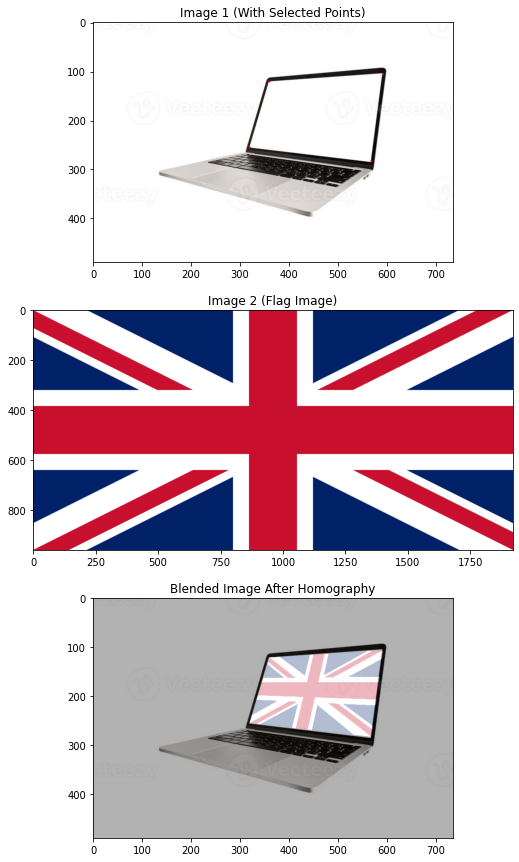

In [41]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

#Load the images for the process
img1 = cv.imread('Data/lap.jpg')
img1 = cv.resize(img1, (0, 0), fx=1, fy=1)
img2 = cv.imread('Data/flag.png')

#Convert images to float64
img1 = img1.astype(np.float64) / 255.0
img2= img2.astype(np.float64) / 255.0

img1_bg = np.copy(img1)

coord = []  # Create a list to store coordinates
count = 0  # Initialize the count to 0

# Define a function to take the corners of the image
def MouseClick(event, x, y, flags, params):
    global coord
    global count
    global img1_bg

    if event == cv.EVENT_LBUTTONDOWN:
        coord.append([x, y])
        count += 1

        img1_bg = cv.circle(img1_bg, (x, y), 2, (0, 0, 1), -1)
        cv.imshow("Custom Image", img1_bg)

    if count == 4: 
        cv.destroyAllWindows()
        cv.waitKey(1)

#Display the image and set the mouse callback
cv.imshow("Custom Image", img1)
cv.setMouseCallback("Custom Image", MouseClick)
cv.waitKey(0)
cv.destroyAllWindows()

# Ensure that we have 4 points
if len(coord) != 4:
    raise ValueError("You must select exactly 4 points.")

# Convert the coordinates to float32 numpy array
points_on_architecture = np.array(coord, dtype=np.float32)

# Define the corresponding points on the flag image (corners of the flag)
points_on_flag = np.array([[0, 0],
                           [img2.shape[1], 0],
                           [img2.shape[1], img2.shape[0]],
                           [0, img2.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv.findHomography(points_on_flag, points_on_architecture)

# Warp the flag image onto the architectural image using the homography
t_IMG_02 = cv.warpPerspective(img2, homography_matrix, (img1.shape[1], img1.shape[0]))

# Blend the warped flag image with the architectural image
beta = 0.3  # Defining the beta value for blending
BlendedIMG = cv.addWeighted(img1, 1 - beta, t_IMG_02, beta, 0.0)

# Ensure pixel values are in the range [0, 1]
BlendedIMG = np.clip(BlendedIMG, 0, 1)

# Convert images to RGB for displaying with matplotlib
BACKGROUND_IMG_rgb = cv.cvtColor((img1_bg * 255).astype(np.uint8), cv.COLOR_BGR2RGB)
IMG_02_rgb = cv.cvtColor((img2 * 255).astype(np.uint8), cv.COLOR_BGR2RGB)
BlendedIMG_rgb = cv.cvtColor((BlendedIMG * 255).astype(np.uint8), cv.COLOR_BGR2RGB)

# Display the images using matplotlib
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].imshow(BACKGROUND_IMG_rgb)
ax[1].imshow(IMG_02_rgb)
ax[2].imshow(BlendedIMG_rgb)

ax[0].set_title("Image 1 (With Clicked Points)")
ax[1].set_title("Image 2 (Flag Image)")
ax[2].set_title("Blended Image After Homography")

plt.show()


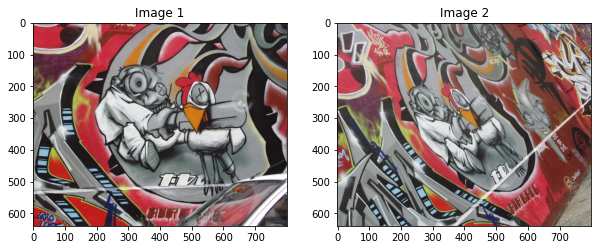

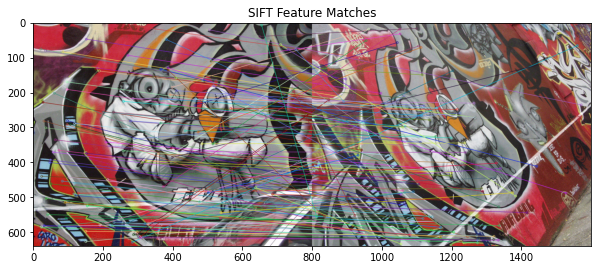

In [61]:
#Load the images
img1 = cv.imread('Data/graf/img1.ppm', cv.IMREAD_ANYCOLOR)
img2 = cv.imread('Data/graf/img4.ppm', cv.IMREAD_ANYCOLOR)

#Plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Image 2')
plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.show()

#Initialize SIFT detector
sift = cv.SIFT_create()

#Find keypoints and descriptors in both images
keypts1, descr1 = sift.detectAndCompute(img1, None)
keypts2, descr2 = sift.detectAndCompute(img2, None)

#Create a brute-force matcher
bfmatch = cv.BFMatcher()

#Match descriptors
matches = bfmatch.knnMatch(descr1, descr2, k=2)

#Apply Lowe's ratio test to filter good matches
good_matches = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
        pts1.append(keypts1[m.queryIdx].pt)
        pts2.append(keypts2[m.trainIdx].pt)

#Draw the matches
match_img = cv.drawMatches(img1, keypts1, img2, keypts2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#Plot the image with matches
plt.figure(figsize=(10, 10))
plt.title('SIFT Feature Matches')
plt.imshow(cv.cvtColor(match_img, cv.COLOR_BGR2RGB))
plt.show()

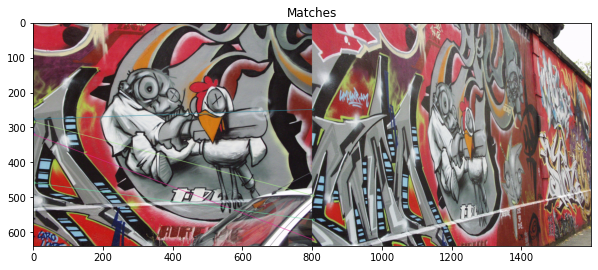

Homography Matrix:
[[ 4.52274495e-01 -4.53691834e-02  6.41720597e+01]
 [ 2.82503325e-01  5.16492016e-01 -6.68257013e+01]
 [-6.41703206e-04 -9.69606480e-05  1.00000000e+00]]
 
Original Homography Matrix:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


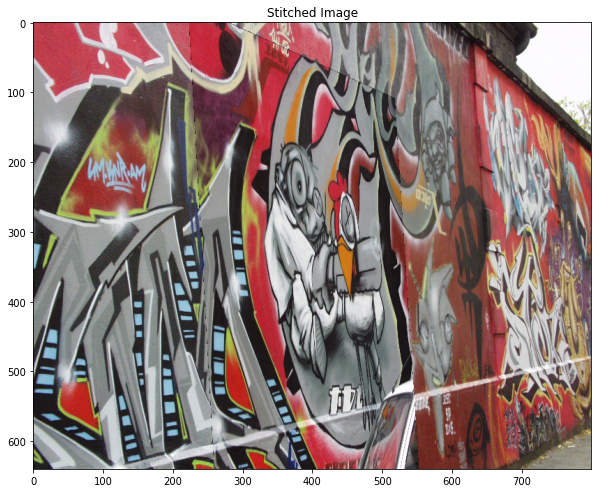

In [62]:
import random

def ransac_matching(img1, img2, num_iterations=1000, max_distance=10, min_inliers=100):
    #Initialize SIFT detector
    sift = cv.SIFT_create()

    # Find keypoints and descriptors in both images
    keypts1, descr1 = sift.detectAndCompute(img1, None)
    keypts2, descr2 = sift.detectAndCompute(img5, None)

    #Create a brute-force matcher
    bf = cv.BFMatcher()

    best_matches = []  #best matches found by RANSAC
    best_homography = None  #best homography matrix
    best_inliers = []  #inliers of the best model

    for _ in range(num_iterations):
        #Randomly select four matches
        random_matches = random.sample(range(len(keypoints1)), 4)

        #Get the keypoints for the selected matches
        src_pts = np.float32([keypts1[m].pt for m in random_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypts2[m].pt for m in random_matches]).reshape(-1, 1, 2)
        

        #Compute the homography matrix
        homography, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, max_distance)

        #Transform keypoints from img1 to img2 using the computed homography
        transformed_pts = cv.perspectiveTransform(src_pts, homography)

        #Calculate the Euclidean distances between transformed and actual keypoints in img2
        distances = np.sqrt(np.sum((dst_pts - transformed_pts) ** 2, axis=2))

        #Count the number of inliers (matches within a certain distance threshold)
        inliers = np.count_nonzero(distances < max_distance)

        #Update if this model has more inliers than the current best
        if inliers > len(best_inliers):
            best_inliers = distances < max_distance
            best_matches = random_matches
            best_homography = homography

        #If we have enough inliers, exit early
        if inliers >= min_inliers:
            break

    #Filter the best matches using inliers
    filtered_matches = [cv.DMatch(i, i, 0) for i, is_inlier in enumerate(best_inliers) if is_inlier]

    return filtered_matches, best_homography, keypoints1, keypoints2

img5 = cv.imread('Data/graf/img5.ppm', cv.IMREAD_ANYCOLOR)


#Find matching points using custom RANSAC
matches, homography, keypoints1, keypoints2 = ransac_matching(img1, img2)

#Draw the matching points
matched_img = cv.drawMatches(img1, keypoints1, img5, keypoints2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#Show the image with matches
plt.figure(figsize=(10, 10))
plt.title('Matches')
plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
plt.show()

print("Homography Matrix:")
print(homography)

print(" ")

#Load homography matrix from file
homography = np.loadtxt('Data/graf/H1to5p')

#Print the original homography matrix
print("Original Homography Matrix:")
print(homography)

#Warp img1 onto img5 using the homography
img1_warped = cv.warpPerspective(img1, homography, (img5.shape[1], img5.shape[0]))

#Create a binary mask of the warped image
_, img1_mask = cv.threshold(cv.cvtColor(img1_warped, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)

#Invert the mask to get the region where img1 should be placed
img5_mask = cv.bitwise_not(img1_mask)

#Blend the two images together
result = cv.bitwise_and(img5, img5, mask=img5_mask)
result = cv.add(result, img1_warped)

#Display the stitched image
plt.figure(figsize=(10, 10))
plt.title('Stitched Image')
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()
